# Owl
## A Retirement Planning Laboratory

This package is a retirement modeling framework for exploring the sensitivity of retirement financial decisions. Strictly speaking, it is not a planning tool, but more an environment for exploring *what if* scenarios. It provides different realizations of a financial strategy. One can certainly have a savings plan, but due to the volatility of financial investments, it is impossible to have a certain asset earnings plan. This does not mean one cannot make decisions. These decisions need to be guided with an understanding of the sensitivity of the parameters.This is exactly where this tool fits it. Given your savings and spending desires, it can generate different future realizations of your strategy under different market assumptions, helping to better understand your financial situation.

The algorithm in Owl is using the open-source HiGHS linear programming solver.
The complete formulation and detailed description of the underlying
mathematical model can be found
[here](https://raw.githubusercontent.com/mdlacasse/Owl/main/docs/owl.pdf).

Copyright - Martin-D. Lacasse (2024)

Disclaimers: *I am not a financial planner. You make your own decisions. This program comes with no guarantee. Use at your own risk.*

### <span style="color: blue"> README FIRST </span>
<span style="color:black;background:yellow;font-weight:bold">
Don't make changes directly to this file. Keep it as a working example. Therefore, it is recommended that you build your own case by making a copy of the template files provided where you will be able to enter your own numbers and explore your own assumptions.
</span>

# Tutorial 3 - Still using the case of Jack and Jill
This tutorial shows how to use advanced capabilities of Owl such as Monte Carlo simulations and running simulations over a historical range. We use the same case as the one in Tutorial 1 and 2 and introduce more Owl's capabilities. 

### Just some Python module bookkeeping
This command needs to be at the beginning of every Owl notebook.

In [1]:
import owl

In [2]:
owl.setVerbose(True)

Setting verbose to True


### Creating the plan (see tutorial 1 for details)
We first create a plan as we did in the *Tutorial 1*. We removed the comments for reducing the clutter.

In [3]:
plan = owl.Plan(['Jack', 'Jill'], [1962, 1965], [89, 92], 'jack+jill-spending-MC')

Preparing scenario of 34 years for 2 individuals.
          Jack: life horizon from 2024 -> 2051.
          Jill: life horizon from 2024 -> 2057.
Problem has 8 distinct time series forming 992 decision variables.
Setting 1st-year starting date to 11/25.


In [4]:
plan.setAccountBalances(
    taxable=[90, 60],
    taxDeferred=[600, 150],
    taxFree=[50 + 20, 40],
)

Taxable balances: $90,000 $60,000
Tax-deferred balances: $600,000 $150,000
Tax-free balances: $70,000 $40,000
Sum of all savings accounts: $1,010,000
Post-tax total wealth of approximately $785,000


In [5]:
plan.readContributions('jack+jill.xlsx')

Reading wages, contributions, conversions, and big-ticket items over time...
	for Jack...
	for Jill...
Successfully read time horizons from file "jack+jill.xlsx".


In [6]:
plan.setInterpolationMethod('s-curve')
plan.setAllocationRatios(
    'individual',
    generic=[[[60, 40, 0, 0], [70, 30, 0, 0]], [[60, 40, 0, 0], [70, 30, 0, 0]]],
)
# plan.showAllocations()

Asset allocation interpolation method set to s-curve.
Jack : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Jill : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Interpolating assets allocation ratios using s-curve method.


In [7]:
plan.setPension([0, 10], [65, 65])
plan.setSocialSecurity([28, 25], [70, 70])

Setting pension of ['$0', '$10,000'] at age(s) [65, 65]
Setting social security benefits of ['$28,000', '$25,000'] at age(s) [70, 70]


In [8]:
plan.setSpendingProfile('smile', 60)
# plan.showProfile()

Setting smile spending profile.
Securing 60% of spending amount for surviving spouse.


### Setting the heirs tax rate

In [9]:
plan.setHeirsTaxRate(33)
plan.setLongTermCapitalTaxRate(15)

Heirs tax rate on tax-deferred portion of estate set to 33%.
Long-term capital gain income tax set to 15%.


### Introducing partial spousal bequest
In some instances, the first spouse to pass can leave a fraction of her/his assets to the surviving spouse. Jack decides to give part of his assets to his children and leave 25% to his surviving spouse. The default values are `[1, 1, 1]`. Changing the beneficiary fractions is done as follows. There is one value for each type of account.

In [10]:
plan.setBeneficiaryFractions([0.25, 0.25, 0.25])
plan.setSpousalDepositFraction(0)

Spousal beneficiary fractions set to [0.25, 0.25, 0.25]
Consider changing spousal deposit fraction for better convergence.
	Recommended: setSpousalDepositFraction(0)
Setting spousal surplus deposit fraction to 0.0.
	Jack: 1.0, Jill: 0.0


### Running a single case
We now run a single case with fixed conservative rates.
Jack and Jill desire to leave a final bequest of \\$200k (in today's \\$). We also limit Roth conversions to a maximum of \\$100k for Jack and none for Jill, similar as the case we ran before.

In [11]:
plan.setRates('conservative')
options = {'maxRothConversion': 100, 'noRothConversions': 'Jill'}
options['solver'] = 'MOSEK'
options['bequest'] = 200
plan.solve('maxSpending', options);
plan.summary()

Using conservative fixed rates values: 6.0% 4.0% 3.3% 2.8%
Generating rate series of 34 years using conservative method.
Adjusting parameters for inflation.
Iteration: 1 objective: $82,990.99
Iteration: 2 objective: $82,769.35
Iteration: 3 objective: $82,769.35
Converged on full solution.
Self-consistent Medicare loop returned after 3 iterations.

Integer solution solution summary
  Problem status  : PRIMAL_FEASIBLE
  Solution status : INTEGER_OPTIMAL
  Primal.  obj: -9.1531161747e+03   nrm: 5e+06    Viol.  con: 1e-10    var: 0e+00    itg: 4e-08  
Objective: $82,769
SUMMARY ================================================================
Plan name: jack+jill-spending-MC
        Jack's life horizon: 2024 -> 2051
        Jill's life horizon: 2024 -> 2057
Contributions file: jack+jill.xlsx
Initial balances [taxable, tax-deferred, tax-free]:
        Jack's accounts: ['$90,000', '$600,000', '$70,000']
        Jill's accounts: ['$60,000', '$150,000', '$40,000']
Return rates: conservative
Rat

Notice the drop in the savings accounts taking place as Jack leaves a partial bequest to Jill in 2051.

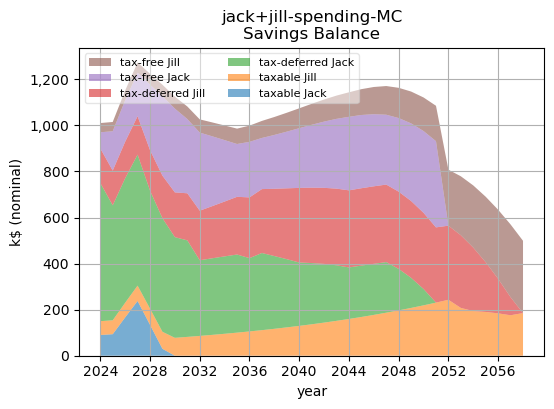

In [12]:
plan.showAccounts()

### Running Monte Carlo simulations
Before running Monte Carlo simulations, we configure the stochastic rate-generating method as explained in Tutorial 2.

In [13]:
# Mean returns
my_means = [8, 5, 4, 3]
# Volatility
my_stdev = [17, 8, 8, 2]
# Correlations matrix between rates of return of different assets
# my_corr = [[1, 0.46, 0.06, -.12], [0.46, 1, 0.68, -.27], [0.06, 0.68, 1, -.21], [-.12, -.27, -.21, 1]]
# These are only the off-diagonal elements
offdiag_corr = [.46, .06, -.12, .68, -.27, -.21]
plan.setRates('stochastic', values=my_means, stdev=my_stdev, corr=offdiag_corr)

Setting rates using stochastic method with means: 8.0% 5.0% 4.0% 3.0%
	 standard deviations: 17.0% 8.0% 8.0% 2.0%
	 and correlation matrix:
		 [[ 1.    0.46  0.06 -0.12]
		 [ 0.46  1.    0.68 -0.27]
		 [ 0.06  0.68  1.   -0.21]
		 [-0.12 -0.27 -0.21  1.  ]]
Generating rate series of 34 years using stochastic method.


In [14]:
# Display a single instance resulting from this choice.
# plan.showRatesCorrelations(shareRange=False)
# plan.showRates()

### Preparing the case to run
We now run many of those cases using the `runMC()` function call. We repeat the options for clarity.

What are these cases telling us?

In [15]:
options = {'maxRothConversion': 100, 'noRothConversions': 'Jill'}
# options['solver'] = 'MOSEK'

|--- progress ---|
	100%
CPU time used: 6m44.0s, elapsed time: 5m2.7s.
Success rate: 100.0% on 500 samples.


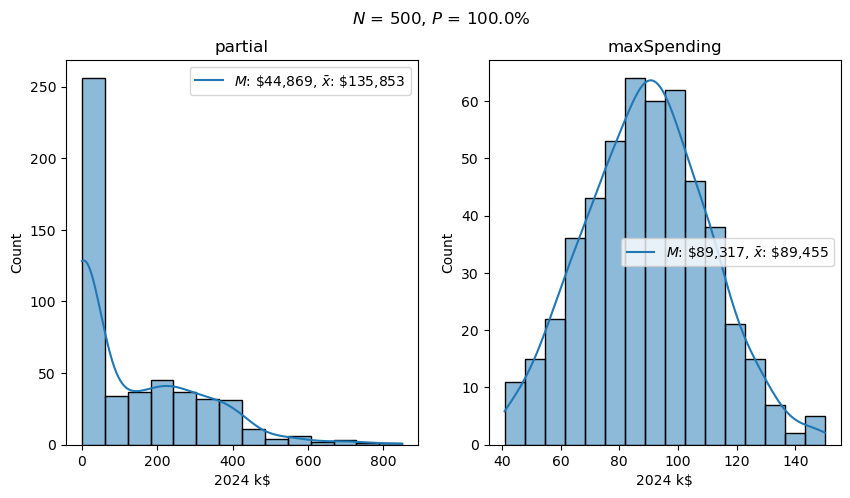

2052: Median (2024 $): $44,869
2052:   Mean (2024 $): $135,853
2057: Median (2024 $): $89,317
2057:   Mean (2024 $): $89,455


In [16]:
options['bequest'] = 200
plan.runMC('maxSpending', options, 500);

Partial is the post-tax partial bequest left to individuals others than the spouse.

All cases are successful at leaving a \\$200k bequest, but the net spending required for achieving this constraint can lead to small values in some scenarios. However, the median value for the net spending is about \\$88k, very close to the \\$90k desired by Jack and Jill. Recall that we are using a more conservative return of 8%, with a volatility of 17% for the S&P 500. It is therefore natural that the number we find here is slightly lower than what the historical return of the market has been able to predict. Some of these scenarios will provide more than the median (\$M\$), but some others will require a net spending of about \\$50k. All these scenarios make a probability of 100\% for leaving a \\$200k bequest as requested. Mean values are indicated by $\bar{x}$. We can see that the mean value left by Jack to his children is about $130k while the median is about $45k.

Similarly, one can look at the maximum bequest left under the constraint of a fixed net spending.

|--- progress ---|
	100%
CPU time used: 4m42.6s, elapsed time: 3m24.2s.
Success rate: 85.0% on 500 samples.


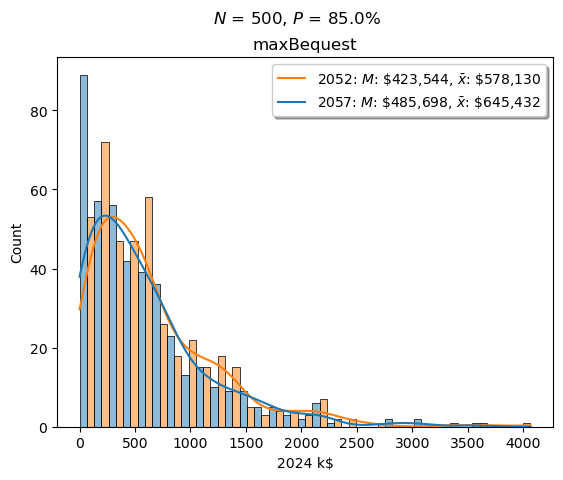

2052: Median (2024 $): $423,544
2052:   Mean (2024 $): $578,130
2057: Median (2024 $): $485,698
2057:   Mean (2024 $): $645,432


In [17]:
options['netSpending'] = 80
plan.runMC('maxBequest', options, 500);

In this case, a relatively large percentage of scenarios are successful in providing the desired \\$80k net spending amount over the duration of the plan. The median bequest left at the end of the plan is close to \\$500k, while Jack's partial bequest is only a little less. AThe success rate is 85%, which is relatively good, especially considering the fact that Jack and Jill are always able to re-adjust their net spending plan as other forecast estimates are performed in the future.

### Running cases over a historical range or years
As with full spousal asset transfer, we can also run the same cases using the historical data over a range of years and compile the outcomes in a histogram. For this purpose, there is no need to pre-select specific rates using the `setRates()` method as the choice of *historical* rates is implicit. Only the year range is required.

Let's look at a specific example. For optimizing the net spending amount, we specify *maxSpending* in the following call to optimize the plan over the 63 years following 1928:

|--- progress ---|
	100%
Success rate: 100.0% on 63 samples.


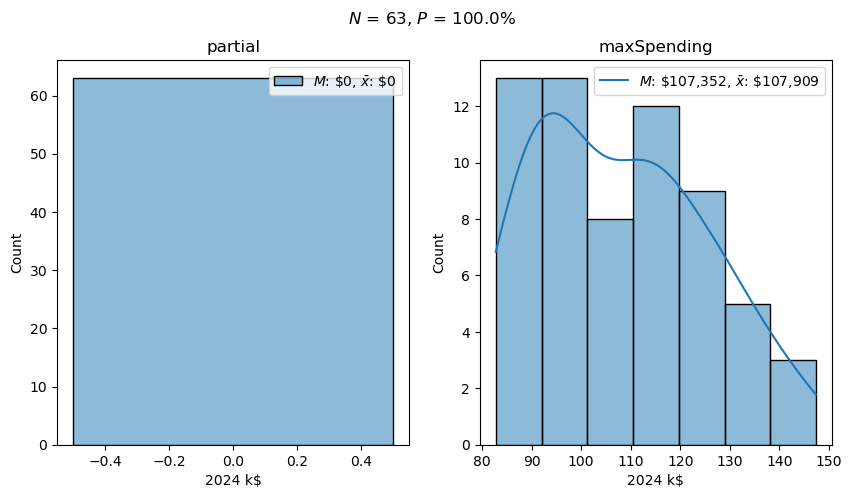

2052: Median (2024 $): $0
2052:   Mean (2024 $): $0
2057: Median (2024 $): $107,352
2057:   Mean (2024 $): $107,909
CPU times: total: 1min 34s
Wall time: 1min 6s


In [18]:
%%time
plan.runHistoricalRange('maxSpending', options, 1928, 1990);

When considering more historical data than a single year, we find a slightly larger net spending value than the one dictated from when only looking at the year 1969. This is not surprising as 1969 was not a good year to retire due to the high inflation rates that prevailed during the following decade. 

Let's now consider the case for *maxBequest* under a desired net spending.

|--- progress ---|
	100%
Success rate: 100.0% on 63 samples.


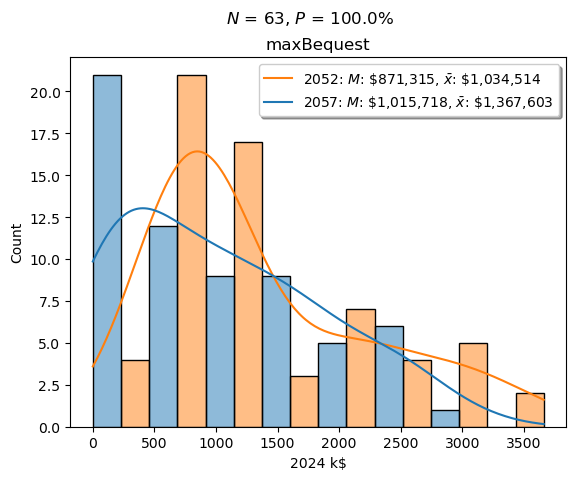

2052: Median (2024 $): $871,315
2052:   Mean (2024 $): $1,034,514
2057: Median (2024 $): $1,015,718
2057:   Mean (2024 $): $1,367,603
CPU times: total: 1min 42s
Wall time: 1min 18s


In [19]:
%%time
plan.runHistoricalRange('maxBequest', options, 1928, 1990);

The resulting success rate when considering all historical data is 100%. This is also not surprising as the original estimates for the net spending and the bequest were derived from running a case in 1969, the second next worst year of historical sequences of returns. 